# Flight Price Predictor ML Project

## Objective

The objective of this project is to develop a machine learning-based flight price predictor system that accurately forecasts the prices of airline tickets. By leveraging historical flight data and relevant features, the model will learn patterns and trends to make reliable predictions on future flight prices. The primary goal is to provide users with a tool that assists them in making informed decisions while planning their travel and enables them to find the best time to book flights at optimal prices.

By achieving these objectives, this project aims to empower users with a reliable and efficient tool that assists them in making informed decisions about flight bookings, ultimately saving them time and money while planning their travel.

It also aims to make the business make better decision

# Import Packages


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Models (Regressors)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Model tools
#from lightgbm import plot_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

# Measurements
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2

# Engineering
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Other
from tqdm.notebook import tqdm
from time import sleep
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'
#sns.set_palette('deep', n_colors=7)
#sns.set_style("whitegrid", {"axes.facecolor": ".9"})

# Import Data

In [ ]:
df_train = pd.read_excel('/Data_Train.xlsx')
df_test = pd.read_excel('/Test_set.xlsx')

df_raw = pd.concat([df_train, df_test], ignore_index=True, sort=False)

In [ ]:
df_raw.to_excel("Raw_data.xlsx")

In [ ]:
print("Row count:", df_raw.shape[0])
print("Column count:", df_raw.shape[1])

Row count: 13354
Column count: 11


In [ ]:
print(df_raw.head())
print()
print(df_raw.tail())
print()
print(df_raw.sample())

       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info    Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897.0  
1    05:50         13:15   7h 25m     2 stops         No info   7662.0  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882.0  
3    18:05         23:30   5h 25m      1 stop         No info   6218.0  
4    16:50         21:35   4h 45m      1 stop         No info  13302.0  

                 Airline Date_of_Journey   Source Destination  \
13349          Air In

# Check for Nulls & Data Types

In [ ]:
df_raw.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
dtype: int64

In [ ]:
df_raw.dtypes

Airline             object
Date_of_Journey     object
Source              object
Destination         object
Route               object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price              float64
dtype: object

# Target Feature (Price) Analysis

,count,mean,std,min,25%,50%,75%,max
Price,10683.0,9087.064121,4611.359167,1759.0,5277.0,8372.0,12373.0,79512.0


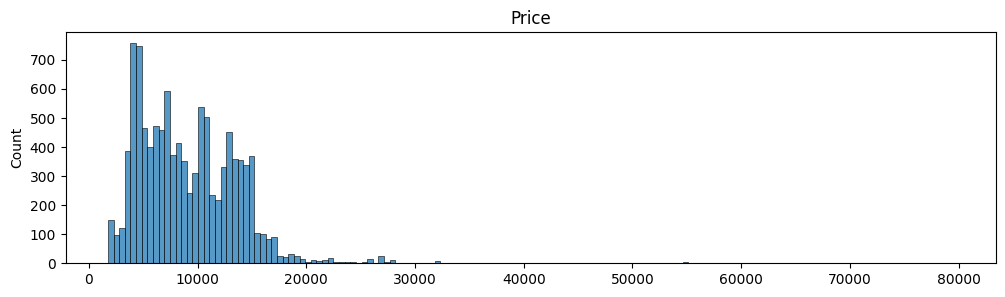

In [ ]:
fig,axes=plt.subplots(figsize=(12, 3))
ax = sns.histplot(df_raw['Price'].values, bins=150).set_title('Price')
df_raw[['Price']].describe().T

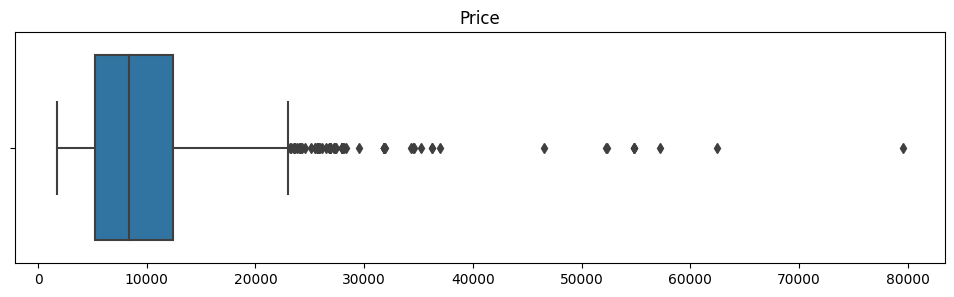

In [ ]:
fig,axes=plt.subplots(figsize=(12, 3))
ax = sns.boxplot(x=df_raw['Price'].values).set_title('Price')

* From Histrogram and Boxplot, clearly there are **outliers heavily skewing flight price data.
* Prices are right skewed by large outliers (20k to 80k price points).

# Visualize Price without Outliers

In [ ]:
print("Number of outliers above 30k:", len(df_raw[df_raw['Price'] > 30000]))

Number of outliers above 30k: 24


,count,mean,std,min,25%,50%,75%,max
Price,10659.0,9012.081434,4294.485874,1759.0,5264.0,8372.0,12373.0,29528.0


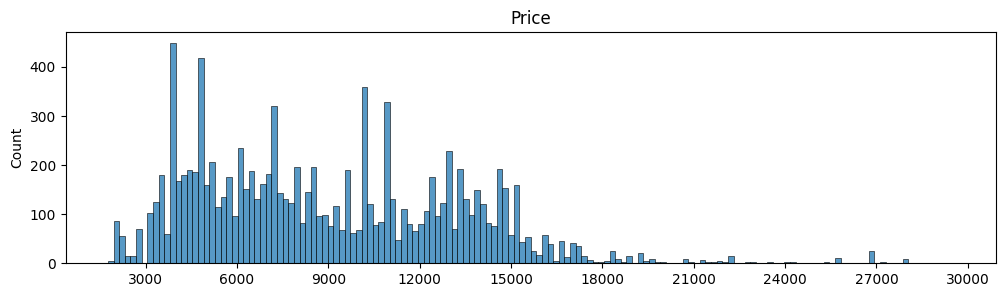

In [ ]:
df_no_out = df_raw[df_raw['Price'] < 30000]

fig,axes=plt.subplots(figsize=(12, 3))
ax = sns.histplot(df_no_out['Price'].values, bins=150).set_title('Price')
plt.xticks([int(x) for x in np.linspace(start=3000,stop=30000,num=10)])
#df_no_out.describe().round(2)
df_no_out[['Price']].describe().T

* Mean decreased from \\$9087 to \\$9012, and SD decreased from \\$4611 to \\$4294 when examining without outliers
* We see that prices mainly hover around \\$5k to \\$7k and \\$13k to \\$14k.

# Investigate all elements for each feature

In [ ]:
# Investigate all elements within each Feature

for column in df_raw:
    try:
        unique_vals = np.unique(df_raw[column])
    except:
        unique_vals = df_raw[column].unique()

    nr_values = len(unique_vals)
    if nr_values < 15:
        print('The number of values for {}: {} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for {}: {}'.format(column, nr_values))

The number of values for Airline: 12 -- ['Air Asia' 'Air India' 'GoAir' 'IndiGo' 'Jet Airways'
 'Jet Airways Business' 'Multiple carriers'
 'Multiple carriers Premium economy' 'SpiceJet' 'Trujet' 'Vistara'
 'Vistara Premium economy']
The number of values for Date_of_Journey: 44
The number of values for Source: 5 -- ['Banglore' 'Chennai' 'Delhi' 'Kolkata' 'Mumbai']
The number of values for Destination: 6 -- ['Banglore' 'Cochin' 'Delhi' 'Hyderabad' 'Kolkata' 'New Delhi']
The number of values for Route: 133
The number of values for Dep_Time: 223
The number of values for Arrival_Time: 1451
The number of values for Duration: 374
The number of values for Total_Stops: 6 -- ['non-stop' '2 stops' '1 stop' '3 stops' nan '4 stops']
The number of values for Additional_Info: 10 -- ['1 Long layover' '1 Short layover' '2 Long layover' 'Business class'
 'Change airports' 'In-flight meal not included' 'No Info'
 'No check-in baggage included' 'No info' 'Red-eye flight']
The number of values for Price: 

**
A quick and effective way to see the values for each columns and the number of unique values.**

**Observations:**
* We can see that there are **12 airlines** and 2 of them are **'business'** and **'premium'** class, might explain the outliers for flight prices.
* Data cleaning like **fixing proper data types** are required for ```Total_Stops```, ```Additional_Info``` and ```Dep/Arrival Time``` columns. 
* Categorical features such as ```Route``` will require some feature engineering to take into consideration the different possible combination of travel.

# Pre-Processing

In [ ]:
df_feat = df_raw.copy()

In [ ]:
## fixing data types

# converting to datetime type and getting the day of week
df_feat['Date_of_Journey'] = pd.to_datetime(df_feat['Date_of_Journey'], format='%d/%m/%Y')
df_feat['Weekday'] = pd.Series(df_feat['Date_of_Journey']).dt.day_name()

# converting to time type only
df_feat['Dep_Time'] = pd.to_datetime(df_feat['Dep_Time'], format='%H:%M')
df_feat['Arrival_Time'] = df_feat['Arrival_Time'].str.split(' ').str[0]
df_feat['Arrival_Time'] = pd.to_datetime(df_feat['Arrival_Time'], format='%H:%M').dt.time

# getting hour,day,month from time
df_feat['Dep_Hr'] = df_feat['Dep_Time'].dt.hour.astype('int')
df_feat['Dep_Day'] = df_feat['Date_of_Journey'].dt.day.astype('int')
df_feat['Dep_Month'] = df_feat['Date_of_Journey'].dt.month.astype('int')

#df_feat['Dep_Hr'] = df_feat['Dep_Hr'].astype('int')
df_feat['Dep_Time'] = pd.to_datetime(df_feat['Dep_Time'], format='%H:%M').dt.time #changing to only time type

# Changing Duration feature from HH:MM to total minutes
hour = pd.to_numeric(df_feat['Duration'].str.replace(r'\D+', ' ', regex=True).str.split(' ').str[0])*60
mins = pd.to_numeric(df_feat['Duration'].str.replace(r'\D+', ' ', regex=True).str.split(' ').str[1])

# some rows dont have mins. hence will become NaN if add hr and min columns tgt.
df_feat['Duration_min'] = np.where(mins.isnull(), hour, hour + mins )

# chaning total_stops to numeric
df_feat.drop(df_feat.index[9039], inplace=True)
df_feat["Total_Stops"] = np.where(df_feat["Total_Stops"] == "non-stop",0,
                         np.where(df_feat["Total_Stops"] == "1 stop",1,
                         np.where(df_feat["Total_Stops"] == "2 stops",2,
                         np.where(df_feat["Total_Stops"] == "3 stops",3,
                         np.where(df_feat["Total_Stops"] == "4 stops",4,0)))))

**Done:**
1. Changing **``Date_of_Journey``**, **`Dep_Time`**, **`Arrival_Time`** to **Datetime** data type.
2. Getting the **Day of week** from **`Date_of_Journey`**. (Mon, Tues, Wed etc.)
3. Getting **hour**, **day** and **month** of travel from **`Date_of_Journey`**.
4. Changing **``Duration``** from **HH:MM (string)** to **total minutes (numerical)** travelled.
5. Changing **``Total_Stops``** from **string** to **numerical (ordinal)** type. 

In [ ]:
df_feat.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Weekday,Dep_Hr,Dep_Day,Dep_Month,Duration_min
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10:00,2h 50m,0,No info,3897.0,Sunday,22,24,3,170.0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15:00,7h 25m,2,No info,7662.0,Wednesday,5,1,5,445.0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25:00,19h,2,No info,13882.0,Sunday,9,9,6,1140.0
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30:00,5h 25m,1,No info,6218.0,Sunday,18,12,5,325.0
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35:00,4h 45m,1,No info,13302.0,Friday,16,1,3,285.0


# EDA

# Transaction Count and Price (Airline Breakdown)

In [ ]:
airline_price_stats = df_feat.groupby('Airline')['Price'].describe()
airline_price_stats.sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
Airline,,,,,,,,
Jet Airways,3849.0,11643.923357,4258.940578,1840.0,9134.0,11467.0,14151.00,54826.0
IndiGo,2053.0,5673.682903,2264.142168,2227.0,4226.0,5000.0,6494.00,22153.0
Air India,1751.0,9612.427756,3901.734561,2050.0,6891.0,9443.0,12219.00,31945.0
Multiple carriers,1196.0,10902.678094,3721.234997,5797.0,7723.0,10197.0,13587.00,36983.0
SpiceJet,818.0,4338.284841,1849.922514,1759.0,3574.5,3873.0,4760.00,23267.0
Vistara,479.0,7796.348643,2914.298578,3687.0,5403.0,7980.0,9345.00,21730.0
Air Asia,319.0,5590.260188,2027.362290,3383.0,4282.0,5162.0,6451.00,13774.0
GoAir,194.0,5861.056701,2703.585767,3398.0,3898.0,5135.0,6811.25,22794.0
Multiple carriers Premium economy,13.0,11418.846154,1717.153936,9845.0,10161.0,11269.0,11269.00,14629.0


<Axes: xlabel='Price', ylabel='Airline'>

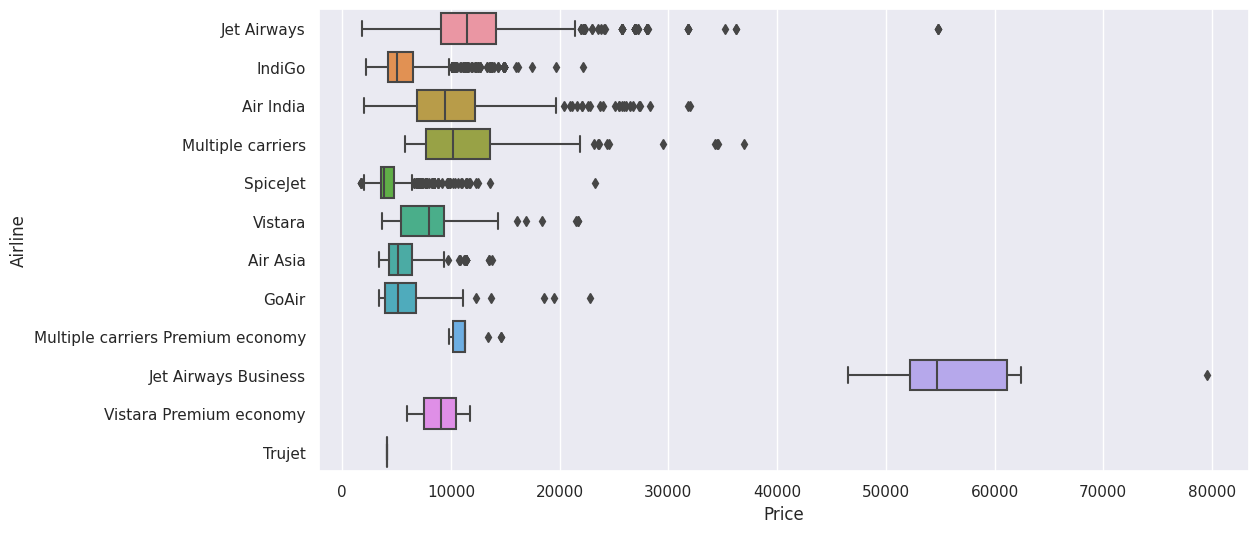

In [ ]:
airline_order = airline_price_stats.sort_values(by=['count'], ascending=False).index
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(data=df_feat, x="Price", y="Airline",order=airline_order)

* differences in price points among the different airlines can be onbserved. 
* Espically **IndiGo** and **SpiceJet** that has **significantly lower prices**. 
* We can observe that the **more expensive prices are from the Business and Premium Airlines** but also with little data on them

# Price breakdown by Total_Stops

<Axes: xlabel='Price', ylabel='Total_Stops'>

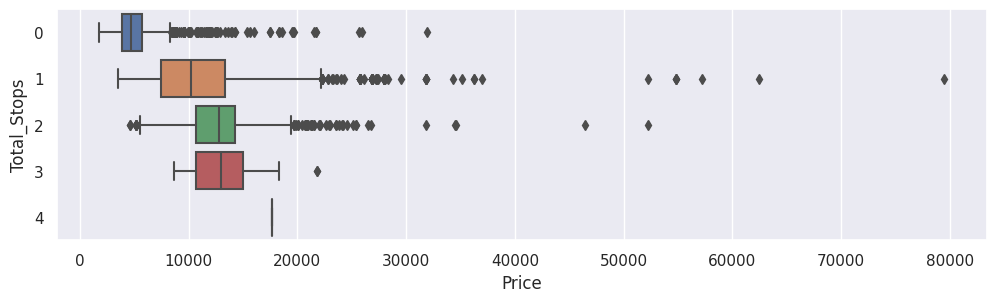

In [ ]:
sns.set(rc={'figure.figsize':(12,3)})
stop_order = [int(x) for x in np.linspace(start=0,stop=4,num=5)]
stop_order = [str(i) for i in stop_order]
sns.boxplot(data=df_feat, x="Price", y=df_feat["Total_Stops"].astype('string'), order=stop_order)

* Clearly direct flights with 0 stops are significantly cheaper. 
* We can also observe that the more number of stops, the more expensive the flight price is

# Relation between Duration & Price

<Axes: xlabel='Duration_min', ylabel='Price'>

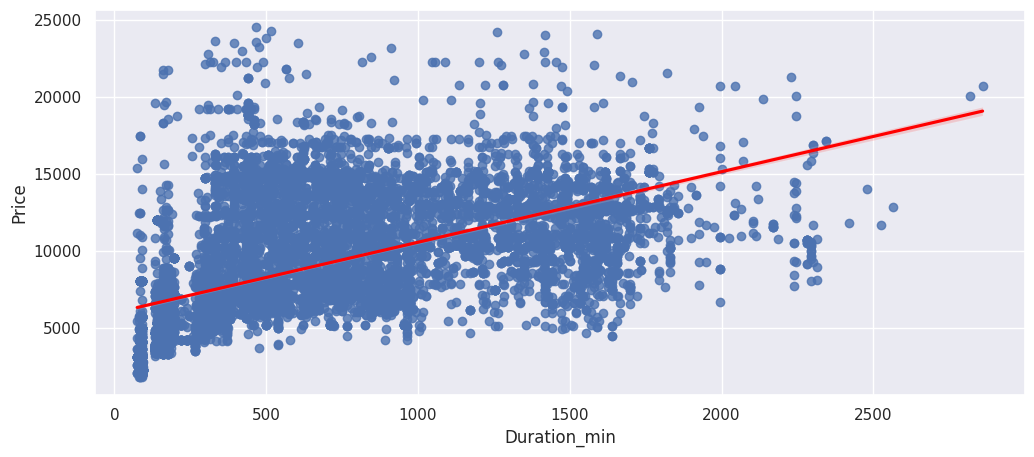

In [ ]:
sns.set(rc={'figure.figsize':(12,5)})
sns.regplot(data=df_feat[df_feat['Price'] < 25000], x='Duration_min', y='Price',
            line_kws = {"color": "red"})


* We do see a **slight positive correlation** between **flight duration and price**.
* **Outliers above 25k** were removed in this analysis.

# Price breakdown by Time/Date Types

## Breakdown by Hours of the day

<Axes: xlabel='Price', ylabel='Dep_Hr'>

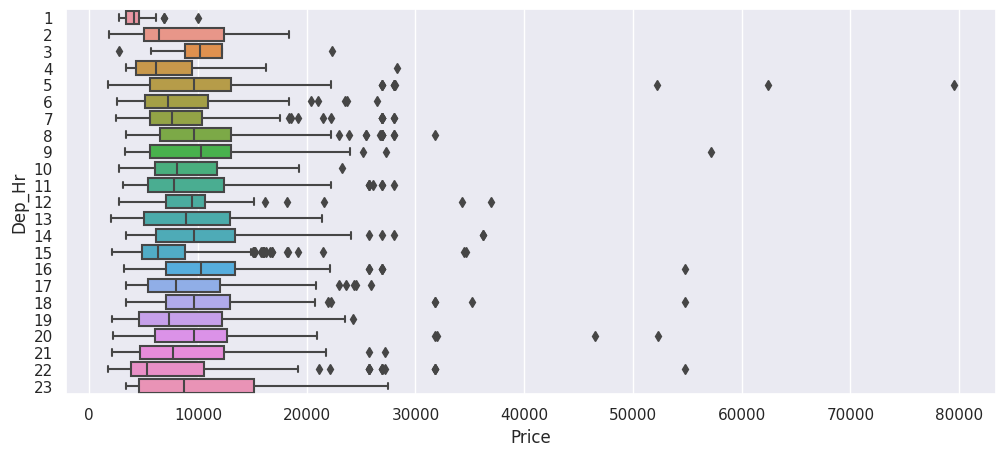

In [ ]:
dep_order = [int(x) for x in np.linspace(start=1,stop=23,num=23)]
dep_order = [str(i) for i in dep_order]
sns.boxplot(data=df_feat, x="Price", y=df_feat["Dep_Hr"].astype('string'), order=dep_order)

## Breakdown by Days of the Month

<Axes: xlabel='Price', ylabel='Dep_Day'>

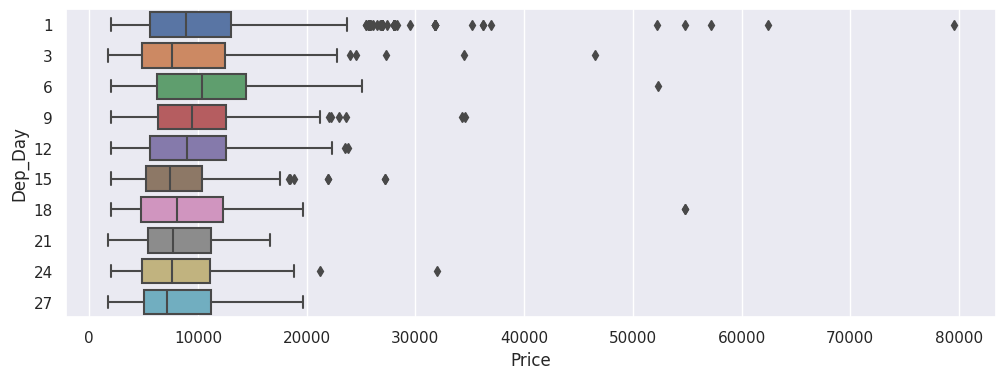

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})
dep_order = np.sort(df_feat["Dep_Day"].unique()).tolist()
dep_order = [str(i) for i in dep_order]
sns.boxplot(data=df_feat, x="Price", y=df_feat["Dep_Day"].astype('string'), order=dep_order)

## Breakdown by Months of the Year

<Axes: xlabel='Price', ylabel='Dep_Month'>

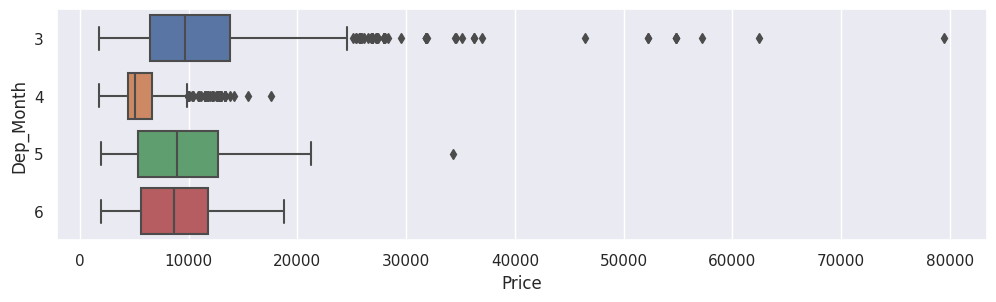

In [ ]:
sns.set(rc={'figure.figsize':(12,3)})
dep_order = np.sort(df_feat["Dep_Month"].unique()).tolist()
dep_order = [str(i) for i in dep_order]
sns.boxplot(data=df_feat, x="Price", y=df_feat["Dep_Month"].astype('string'), order=dep_order)

## Price by "Additional Info" Breakdown

In [ ]:
airline_price_stats = df_feat.groupby('Additional_Info')['Price'].describe()
airline_price_stats.sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
Additional_Info,,,,,,,,
No info,8344.0,9141.519295,4714.347572,1759.0,5224.0,8016.0,12970.00,54826.0
In-flight meal not included,1982.0,9471.834511,2812.043362,1840.0,7757.0,10262.0,10844.00,19644.0
No check-in baggage included,320.0,3645.156250,865.712619,1965.0,3543.0,3841.0,3859.00,6356.0
1 Long layover,19.0,22109.631579,8040.051155,7744.0,14673.0,25735.0,27992.00,31825.0
Change airports,7.0,16800.714286,4449.728371,13366.0,13940.5,15119.0,17573.50,26092.0
Business class,4.0,56811.250000,21381.667044,28097.0,49931.0,59818.0,66698.25,79512.0
No Info,3.0,8044.666667,119.181934,7917.0,7990.5,8064.0,8108.50,8153.0
1 Short layover,1.0,26743.000000,NaN,26743.0,26743.0,26743.0,26743.00,26743.0
2 Long layover,1.0,26480.000000,NaN,26480.0,26480.0,26480.0,26480.00,26480.0


<Axes: xlabel='Price', ylabel='Additional_Info'>

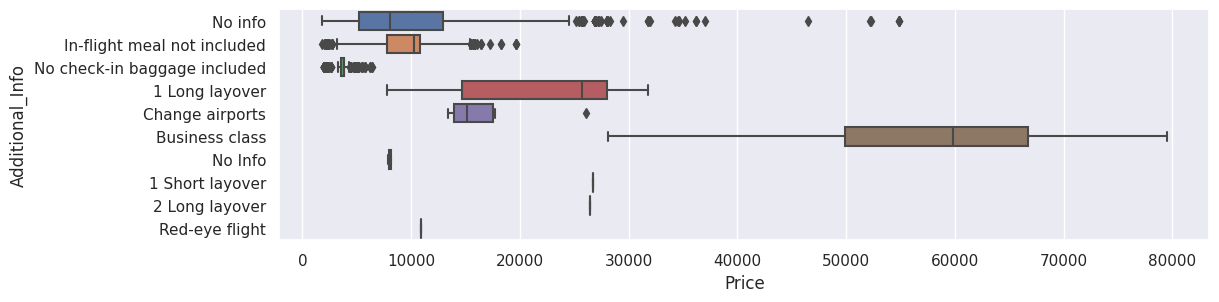

In [ ]:
info_order = airline_price_stats.sort_values(by=['count'], ascending=False).index.tolist()
sns.set(rc={'figure.figsize':(12,3)})
sns.boxplot(data=df_feat, x="Price", y=df_feat["Additional_Info"].astype('string'), order = info_order)

* We can observe that flight prices are generally cheaper when there are no info

# Airline transactions and Price Trend

total flight transactions: 10682


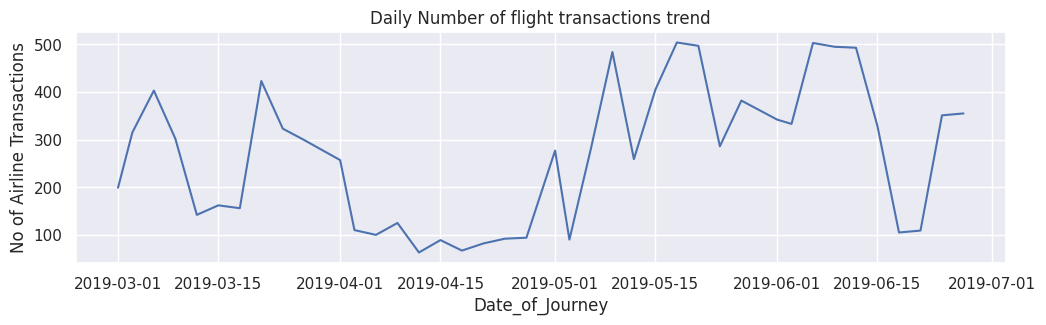

In [ ]:
sns.set(rc={'figure.figsize':(12,3)})
date_count = df_feat[df_feat['Price'].notnull()].groupby('Date_of_Journey').count().reset_index()
g = sns.lineplot(data=date_count, x="Date_of_Journey", y="Airline")
g.set_title('Daily Number of flight transactions trend')
g.set_ylabel('No of Airline Transactions')

print('total flight transactions:' ,len(df_feat[df_feat['Price'].notnull()]))

Text(0.5, 1.0, 'Daily Average Price trend')

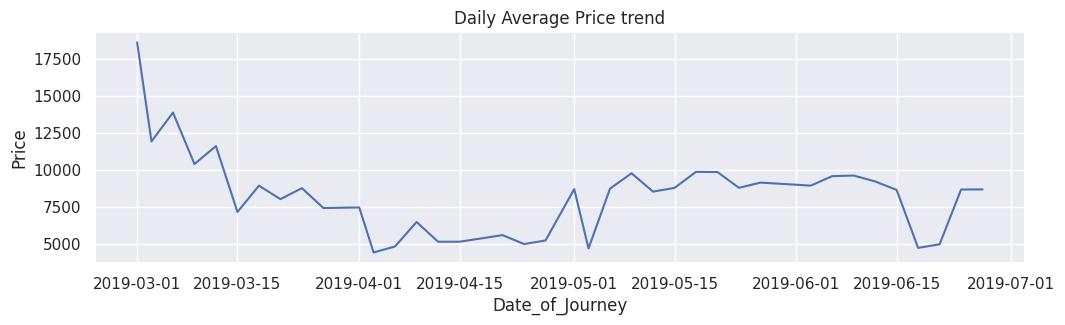

In [ ]:
sns.set(rc={'figure.figsize':(12,3)})
avg_price_time = df_feat[df_feat['Airline'] != 'Jet Airways Business'].groupby('Date_of_Journey').mean('Price').reset_index()
g = sns.lineplot(x="Date_of_Journey", y="Price", data=avg_price_time)
g.set_title('Daily Average Price trend')

# Daily Average Flight Price for each airline

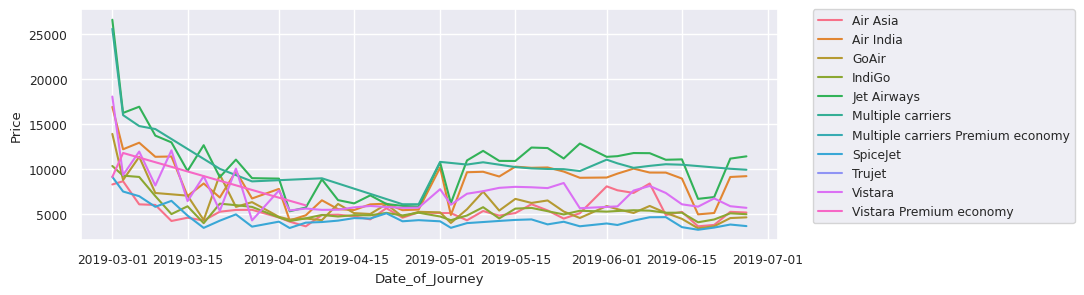

In [ ]:
sns.set(rc={'figure.figsize':(9,3)})
sns.set(font_scale=0.8)
avg_air_price_time = df_feat.groupby(['Airline','Date_of_Journey']).mean('Price').reset_index()
sns.lineplot(x="Date_of_Journey", y="Price", hue='Airline', data=avg_air_price_time[avg_air_price_time['Airline'] != 'Jet Airways Business'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


* The daily average price trends among the different airlins tend to generally follow the same trend

#  Analyzing most common route

In [ ]:
df_feat['Route'].value_counts().head(5)

DEL → BOM → COK    3000
BLR → DEL          1941
CCU → BOM → BLR    1232
CCU → BLR           896
BOM → HYD           785
Name: Route, dtype: int64

In [ ]:
stops3 = df_feat[(df_feat['Source'] == 'Delhi') & (df_feat['Destination'] == 'Cochin') & (df_feat['Total_Stops']==1)]
stops3 = stops3.groupby('Route')[['Price', 'Duration_min']].mean().reset_index().sort_values('Price')
stops3

,Route,Price,Duration_min
0,DEL → AMD → COK,5606.200000,376.333333
7,DEL → PNQ → COK,6602.071429,279.285714
5,DEL → LKO → COK,7166.176471,329.782609
4,DEL → HYD → COK,7299.331288,576.143552
6,DEL → MAA → COK,7312.431507,756.315789
2,DEL → BLR → COK,7559.612069,605.313589
8,DEL → TRV → COK,7835.625000,1409.500000
3,DEL → BOM → COK,10954.205808,735.758333
1,DEL → BBI → COK,11062.600000,355.000000


* Seems like the inter stop between Del & Cok does have a difference in flight price
* Important to take note of the inter stops between departure and destination in our prediction model

# Route into individual columns

In [ ]:
df_post = df_feat[['Airline', 'Source', 'Destination', 'Route', 'Total_Stops',
                   'Additional_Info', 'Dep_Hr','Dep_Day','Dep_Month', 'Weekday', 'Duration_min', 'Price']]

In [ ]:
df_post.head(10)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Dep_Hr,Dep_Day,Dep_Month,Weekday,Duration_min,Price
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,No info,22,24,3,Sunday,170.0,3897.0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,5,1,5,Wednesday,445.0,7662.0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,9,9,6,Sunday,1140.0,13882.0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info,18,12,5,Sunday,325.0,6218.0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,No info,16,1,3,Friday,285.0,13302.0
5,SpiceJet,Kolkata,Banglore,CCU → BLR,0,No info,9,24,6,Monday,145.0,3873.0
6,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1,In-flight meal not included,18,12,3,Tuesday,930.0,11087.0
7,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1,No info,8,1,3,Friday,1265.0,22270.0
8,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1,In-flight meal not included,8,12,3,Tuesday,1530.0,11087.0
9,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1,No info,11,27,5,Monday,470.0,8625.0


In [ ]:
df_post[['Route1', 'Route2', 'Route3', 'Route4', 'Route5', 'Route6' ]] = df_post['Route'].str.split('→', expand=True)

In [ ]:
# keeping route2 to route5
df_post['Route2'] = np.where(df_post['Total_Stops'] == 0, None, df_post['Route2'])
df_post['Route3'] = np.where(df_post['Total_Stops'] == 1, None, df_post['Route3'])
df_post['Route4'] = np.where(df_post['Total_Stops'] == 2, None, df_post['Route4'])
df_post['Route5'] = np.where(df_post['Total_Stops'] == 3, None, df_post['Route5'])
df_post['Route6'] = np.where(df_post['Total_Stops'] == 4, None, df_post['Route6'])
df_post = df_post.drop(['Route1', 'Route6'], axis=1)

In [ ]:
df_post[['Route', 'Total_Stops', 'Route2', 'Route3', 'Route4', 'Route5']][df_post['Total_Stops']==4].sample(2)

,Route,Total_Stops,Route2,Route3,Route4,Route5
13105,BLR → CCU → BBI → HYD → VGA → DEL,4,CCU,BBI,HYD,VGA
9182,BLR → CCU → BBI → HYD → VGA → DEL,4,CCU,BBI,HYD,VGA


* In this step we are splitting the "Route" Column into 6 columns (Route1 to Route 6)
* As the highest number of stops is 6, including depature and destination stop we have 6 columns
* However, since there are columns 'Depature' and 'Destination', we will then drop Route1 and Route6 which represents thte same.

In [ ]:
route_top15 = df_post['Route'].value_counts().head(15).index.tolist()

In [ ]:
df_post['Route'] = df_post['Route'].apply(lambda i: i if i in route_top15 else 'Others')

In [ ]:
df_post.sample(5)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Dep_Hr,Dep_Day,Dep_Month,Weekday,Duration_min,Price,Route2,Route3,Route4,Route5
3756,Jet Airways,Kolkata,Banglore,CCU → BOM → BLR,1,In-flight meal not included,14,24,5,Friday,1575.0,10844.0,BOM,None,None,None
4404,Jet Airways,Kolkata,Banglore,CCU → BOM → BLR,1,In-flight meal not included,18,21,5,Tuesday,585.0,9663.0,BOM,None,None,None
7747,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1,In-flight meal not included,6,9,3,Saturday,745.0,14817.0,BOM,None,None,None
10505,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1,No info,7,21,3,Thursday,840.0,7618.0,BOM,None,None,None
10092,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1,No info,10,15,6,Saturday,535.0,9526.0,BOM,None,None,None


# Get dummies for categorical features

In [ ]:
df_final = pd.get_dummies(df_post, columns = ['Airline', 'Source', 'Destination',
                                               'Additional_Info', 'Weekday'], drop_first=True)
df_final = df_final.drop(['Route'], axis=1)

In [ ]:
df_final.sample(3)

,Total_Stops,Dep_Hr,Dep_Day,Dep_Month,Duration_min,Price,Route2,Route3,Route4,Route5,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
6879,0,20,3,3,90.0,5232.0,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
6694,1,8,24,3,850.0,10031.0,BOM,None,None,None,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2366,2,11,24,6,440.0,15812.0,JDH,BOM,None,None,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [ ]:
print("Row count:", df_final.shape[0])
print("Column count:", df_final.shape[1])

Row count: 13353
Column count: 45


In [ ]:
route2_dict = {}
count=0
for i in df_final['Route2'].unique():
    route2_dict[i] = count
    count+=1

route3_dict = {}
count=0
for i in df_final['Route3'].unique():
    route3_dict[i] = count
    count+=1

for k,v in route3_dict.items():
    if k not in route2_dict:
        route2_dict[k] = v

In [ ]:
df_final["Route2"] = df_final["Route2"].map(route2_dict)
df_final["Route3"] = df_final["Route3"].map(route2_dict)
df_final["Route4"] = df_final["Route4"].map(route2_dict)
df_final["Route5"] = df_final["Route5"].map(route2_dict)

In [ ]:
df_final[['Total_Stops', 'Route2', 'Route3', 'Route4', 'Route5']][df_final['Total_Stops']==4].sample(2)

,Total_Stops,Route2,Route3,Route4,Route5
13105,4,8,19,13,28
9182,4,8,19,13,28


# Correlation between features and target feature

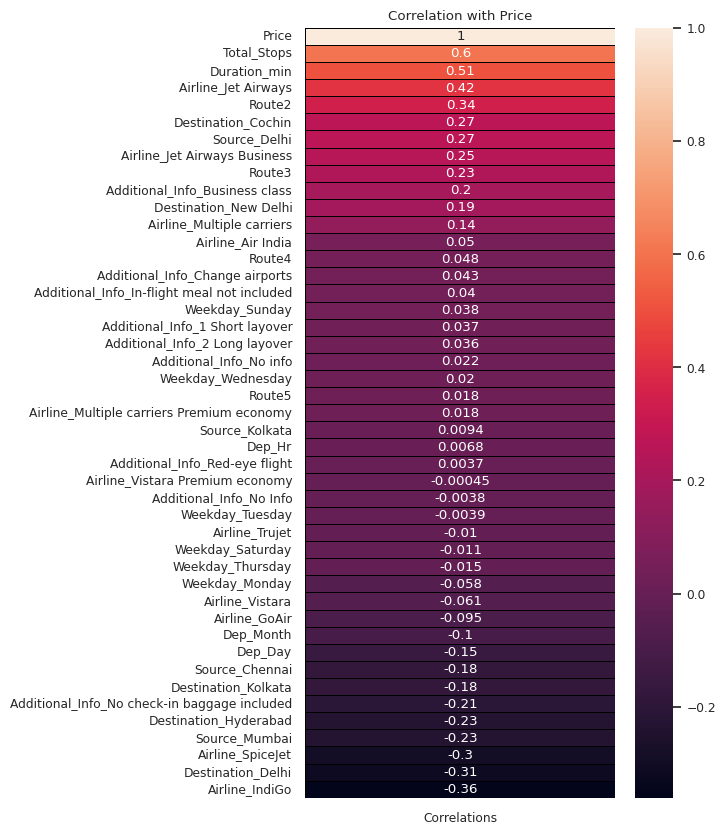

In [ ]:
corr = df_final.corrwith(df_final['Price']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,10))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation with Price');

# Train Test Split

In [ ]:
df_final = df_final[df_final['Price'].notnull()]

X = df_final.drop(['Price'], axis=1)
y = df_final['Price'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Base Models

In [ ]:
models = []
rmse_lst = []
mse_lst = []
r2_lst = []

# Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)
mse = float(format(mean_squared_error(y_test, y_pred), '.3f'))
print("MSE: ", mse)
r2 = float(format(r2_score(y_test, y_pred), '.3f'))
print("R2: ", r2)

models.append('Random Forest')
rmse_lst.append(rmse)
mse_lst.append(mse)
r2_lst.append(r2)

RMSE:  1461.637
MSE:  2136383.637
R2:  0.896


In [ ]:
rfr_importance = rfr.feature_importances_
rfr_names = rfr.feature_names_in_

rfr_import_df = pd.DataFrame({"feature_names" : rfr_names,
                               "rfr_importances" : rfr_importance.round(3)})
rfr_import_df['rfr_impt_rank'] = rfr_import_df['rfr_importances'].rank(method='dense', ascending=False)

In [ ]:
rfr_import_df.sort_values('rfr_importances', ascending=False).head(7)

,feature_names,rfr_importances,rfr_impt_rank
4,Duration_min,0.462,1.0
2,Dep_Day,0.085,2.0
33,Additional_Info_In-flight meal not included,0.078,3.0
13,Airline_Jet Airways Business,0.061,4.0
12,Airline_Jet Airways,0.059,5.0
3,Dep_Month,0.048,6.0
1,Dep_Hr,0.031,7.0


# XGBoost Regressor

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)
mse = float(format(mean_squared_error(y_test, y_pred), '.3f'))
print("MSE: ", mse)
r2 = float(format(r2_score(y_test, y_pred), '.3f'))
print("R2: ", r2)

models.append('XGBoost')
rmse_lst.append(rmse)
mse_lst.append(mse)
r2_lst.append(r2)

RMSE:  1400.901
MSE:  1962524.463
R2:  0.905


# Gradient Boosting Regressor

In [ ]:
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)
mse = float(format(mean_squared_error(y_test, y_pred), '.3f'))
print("MSE: ", mse)
r2 = float(format(r2_score(y_test, y_pred), '.3f'))
print("R2: ", r2)

models.append('Gradient Boost')
rmse_lst.append(rmse)
mse_lst.append(mse)
r2_lst.append(r2)

RMSE:  1768.741
MSE:  3128445.926
R2:  0.848


In [ ]:
gbr_importance = gbr.feature_importances_
gbr_names = gbr.feature_names_in_

gbr_import_df = pd.DataFrame({"feature_names" : gbr_names,
                               "gbr_importances" : gbr_importance.round(3)})
gbr_import_df['gbr_impt_rank'] = gbr_import_df['gbr_importances'].rank(method='dense', ascending=False)

In [ ]:
gbr_import_df.sort_values('gbr_importances', ascending=False).head(7)

,feature_names,gbr_importances,gbr_impt_rank
4,Duration_min,0.493,1.0
2,Dep_Day,0.101,2.0
12,Airline_Jet Airways,0.079,3.0
33,Additional_Info_In-flight meal not included,0.075,4.0
13,Airline_Jet Airways Business,0.075,4.0
3,Dep_Month,0.044,5.0
6,Route3,0.031,6.0


In [ ]:
xgb_importance = xgb.feature_importances_
xgb_names = xgb.feature_names_in_

xgb_import_df = pd.DataFrame({"feature_names" : xgb_names,
                               "xgb_importances" : xgb_importance.round(3)})
xgb_import_df['xgb_impt_rank'] = xgb_import_df['xgb_importances'].rank(method='dense', ascending=False)

In [ ]:
xgb_import_df.sort_values('xgb_importances', ascending=False).head(7)

,feature_names,xgb_importances,xgb_impt_rank
13,Airline_Jet Airways Business,0.454,1.0
12,Airline_Jet Airways,0.093,2.0
33,Additional_Info_In-flight meal not included,0.074,3.0
4,Duration_min,0.052,4.0
28,Destination_New Delhi,0.037,5.0
11,Airline_IndiGo,0.036,6.0
0,Total_Stops,0.023,7.0


# Summary

In [ ]:

data = {'models': models,
        'rmse': rmse_lst,
        'mse': mse_lst,
        'r2': r2_lst
        }

df_result_sum = pd.DataFrame(data)

In [ ]:
df_result_sum

,models,rmse,mse,r2
0,Random Forest,1461.637,2136383.637,0.896
1,XGBoost,1400.901,1962524.463,0.905
2,Gradient Boost,1768.741,3128445.926,0.848


In [ ]:
sum_import_df = rfr_import_df.merge(xgb_import_df,on='feature_names').merge(gbr_import_df,on='feature_names')
sum_import_df['overall_score'] = sum_import_df['rfr_impt_rank'] + sum_import_df['xgb_impt_rank'] + sum_import_df['gbr_impt_rank']
sum_import_df['overall_rank'] = sum_import_df['overall_score'].rank(method='dense', ascending=True)

In [ ]:
sum_import_df.sort_values('overall_rank', ascending=True)[['feature_names', 'rfr_impt_rank', 'xgb_impt_rank', 'gbr_impt_rank', 'overall_score', 'overall_rank']]

,feature_names,rfr_impt_rank,xgb_impt_rank,gbr_impt_rank,overall_score,overall_rank
4,Duration_min,1.0,4.0,1.0,6.0,1.0
13,Airline_Jet Airways Business,4.0,1.0,4.0,9.0,2.0
33,Additional_Info_In-flight meal not included,3.0,3.0,4.0,10.0,3.0
12,Airline_Jet Airways,5.0,2.0,3.0,10.0,3.0
2,Dep_Day,2.0,9.0,2.0,13.0,4.0
3,Dep_Month,6.0,11.0,5.0,22.0,5.0
28,Destination_New Delhi,9.0,5.0,9.0,23.0,6.0
11,Airline_IndiGo,13.0,6.0,7.0,26.0,7.0
6,Route3,10.0,12.0,6.0,28.0,8.0
14,Airline_Multiple carriers,11.0,8.0,10.0,29.0,9.0


# Hyper Parameter Tunning

# Random Forest

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=900,stop=1400,num=6)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(30, 70, num = 6)] # Max number of levels in tree
min_samples_split = [3,5,10,12,15,17,20] # Min number of samples required to split a node
min_samples_leaf = [1, 2, 5, 10] # Min number of samples requred at each leaft node

rf_param_grid = {

    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

print(rf_param_grid)

{'n_estimators': [900, 1000, 1100, 1200, 1300, 1400], 'max_features': ['auto', 'sqrt'], 'max_depth': [30, 38, 46, 54, 62, 70], 'min_samples_split': [3, 5, 10, 12, 15, 17, 20], 'min_samples_leaf': [1, 2, 5, 10]}


In [ ]:
rfr=RandomForestRegressor()
rf_tunned = RandomizedSearchCV(scoring='neg_mean_squared_error', estimator = rfr, param_distributions = rf_param_grid, n_iter=30, cv=5, verbose=2, n_jobs=1)
rf_tunned.fit(X_train,y_train)

In [ ]:
rf_tunned.best_params_

{'n_estimators': 900,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 46}

In [ ]:
y_pred = rf_tunned.predict(X_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)
mse = float(format(mean_squared_error(y_test, y_pred), '.3f'))
print("MSE: ", mse)
r2 = float(format(r2_score(y_test, y_pred), '.3f'))
print("R2: ", r2)

models.append('Random Forest (t)')
rmse_lst.append(rmse)
mse_lst.append(mse)
r2_lst.append(r2)

RMSE:  1474.491
MSE:  2174124.841
R2:  0.895


In [ ]:
rf_tunned_importance = rf_tunned.best_estimator_.feature_importances_
rf_tunned_names = rf_tunned.best_estimator_.feature_names_in_

rf_tunned_import_df = pd.DataFrame({"feature_names" : rf_tunned_names,
                               "rf_tunned_importances" : rf_tunned_importance.round(3)})
rf_tunned_import_df['rf_tunned_impt_rank'] = rf_tunned_import_df['rf_tunned_importances'].rank(method='dense', ascending=False)

# XG Boost

In [ ]:
params = {
 "n_estimators": [int(x) for x in np.linspace(start=400,stop=700,num=7)], # Number of trees in random forest
 "learning_rate" : [0.01,0.02,0.04, 0.05,0.06,0.07],
 "max_depth" : [ 3, 4, 5, 6, 8, 10],
 "min_child_weight" : [2, 3, 4, 5],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 ,0.6, 0.7 ]
}



In [ ]:
###### xgb = XGBRegressor()
xgb_model_tuned = RandomizedSearchCV(estimator = xgb, param_distributions = params, scoring='neg_mean_squared_error', n_iter = 30, cv = 5, verbose=2, random_state=42, n_jobs = 1)
xgb_model_tuned.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.04, max_depth=8, min_child_weight=5, n_estimators=450; total time=   4.8s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.04, max_depth=8, min_child_weight=5, n_estimators=450; total time=   4.6s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.04, max_depth=8, min_child_weight=5, n_estimators=450; total time=   6.9s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.04, max_depth=8, min_child_weight=5, n_estimators=450; total time=   4.6s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.04, max_depth=8, min_child_weight=5, n_estimators=450; total time=   6.9s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.06, max_depth=3, min_child_weight=2, n_estimators=550; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.06, max_depth=3, min_child_weight=2, n_estimators=550; total time=   1.9s
[CV] END colsa

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor=None, random_state=None, ...),
                   n_iter=30, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.02, 0.04,
                                                          0.05, 0.06, 0.07],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'min_child_weight': [2, 3, 4, 5],
                                        'n_estimators': [400, 450, 500, 550,
                                                         600, 650, 700]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
xgb_model_tuned.best_params_

{'n_estimators': 450,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.4,
 'colsample_bytree': 0.6}

In [ ]:
y_pred = xgb_model_tuned.predict(X_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)
mse = float(format(mean_squared_error(y_test, y_pred), '.3f'))
print("MSE: ", mse)
r2 = float(format(r2_score(y_test, y_pred), '.3f'))
print("R2: ", r2)


models.append('XGBoost (t)')
rmse_lst.append(rmse)
mse_lst.append(mse)
r2_lst.append(r2)

RMSE:  1329.299
MSE:  1767036.443
R2:  0.914


In [ ]:
xgb_tunned_importance = xgb_model_tuned.best_estimator_.feature_importances_
xgb_tunned_names = xgb_model_tuned.best_estimator_.feature_names_in_

xgb_tunned_import_df = pd.DataFrame({"feature_names" : xgb_tunned_names,
                               "xgb_tunned_importances" : xgb_tunned_importance.round(3)})
xgb_tunned_import_df['xgb_tunned_impt_rank'] = xgb_tunned_import_df['xgb_tunned_importances'].rank(method='dense', ascending=False)

In [ ]:
xgb_tunned_import_df.sort_values('xgb_tunned_importances', ascending=False).head(7)

,feature_names,xgb_tunned_importances,xgb_tunned_impt_rank
13,Airline_Jet Airways Business,0.351,1.0
31,Additional_Info_Business class,0.115,2.0
12,Airline_Jet Airways,0.088,3.0
0,Total_Stops,0.059,4.0
33,Additional_Info_In-flight meal not included,0.043,5.0
11,Airline_IndiGo,0.041,6.0
4,Duration_min,0.036,7.0


# Gradient Boosting

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=50,stop=200,num=10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [10,12,13,14,15,17] # Max number of levels in tree
min_samples_split = [10,15,18,20,22,24] # Min number of samples required to split a node
min_samples_leaf = [2,3,4,5,7,10] # Min number of samples requred at each leaft node

gbr_param_grid = {

    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}


In [ ]:
gbr = GradientBoostingRegressor(learning_rate=0.1, loss='squared_error')
gbr_tunned = RandomizedSearchCV(estimator = gbr, param_distributions = gbr_param_grid, n_iter=30, cv=5, verbose=2, n_jobs=1)
gbr_tunned.fit(X_train,y_train)

In [ ]:
gbr_tunned.best_params_

{'n_estimators': 116,
 'min_samples_split': 18,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10}

In [ ]:
y_pred = gbr_tunned.predict(X_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)
mse = float(format(mean_squared_error(y_test, y_pred), '.3f'))
print("MSE: ", mse)
r2 = float(format(r2_score(y_test, y_pred), '.3f'))
print("R2: ", r2)


models.append('Gradient Boost (t)')
rmse_lst.append(rmse)
mse_lst.append(mse)
r2_lst.append(r2)

RMSE:  1403.385
MSE:  1969488.458
R2:  0.904


In [ ]:
gbr_tunned_importance = gbr_tunned.best_estimator_.feature_importances_
gbr_tunned_names = gbr_tunned.best_estimator_.feature_names_in_

gbr_tunned_import_df = pd.DataFrame({"feature_names" : gbr_tunned_names,
                               "gbr_tunned_importances" : gbr_tunned_importance.round(3)})
gbr_tunned_import_df['gbr_tunned_impt_rank'] = gbr_tunned_import_df['gbr_tunned_importances'].rank(method='dense', ascending=False)

In [ ]:
gbr_tunned_import_df.sort_values('gbr_tunned_importances', ascending=False).head(15)

,feature_names,gbr_tunned_importances,gbr_tunned_impt_rank
4,Duration_min,0.168,1.0
0,Total_Stops,0.163,2.0
5,Route2,0.121,3.0
2,Dep_Day,0.080,4.0
12,Airline_Jet Airways,0.071,5.0
3,Dep_Month,0.045,6.0
13,Airline_Jet Airways Business,0.042,7.0
11,Airline_IndiGo,0.038,8.0
6,Route3,0.031,9.0
33,Additional_Info_In-flight meal not included,0.031,9.0


In [ ]:
sum_import_df_tunned = rf_tunned_import_df.merge(xgb_tunned_import_df,on='feature_names').merge(gbr_tunned_import_df,on='feature_names')
sum_import_df_tunned['overall_score'] = sum_import_df_tunned['rf_tunned_impt_rank'] + sum_import_df_tunned['xgb_tunned_impt_rank'] + sum_import_df_tunned['gbr_tunned_impt_rank']
sum_import_df_tunned['overall_rank'] = sum_import_df_tunned['overall_score'].rank(method='dense', ascending=True)

In [ ]:
sum_import_df_tunned.sort_values('overall_rank', ascending=True)[['feature_names', 'rf_tunned_impt_rank', 'xgb_tunned_impt_rank', 'gbr_tunned_impt_rank', 'overall_score', 'overall_rank']]

,feature_names,rf_tunned_impt_rank,xgb_tunned_impt_rank,gbr_tunned_impt_rank,overall_score,overall_rank
4,Duration_min,1.0,7.0,1.0,9.0,1.0
13,Airline_Jet Airways Business,4.0,1.0,7.0,12.0,2.0
12,Airline_Jet Airways,5.0,3.0,5.0,13.0,3.0
33,Additional_Info_In-flight meal not included,2.0,5.0,9.0,16.0,4.0
0,Total_Stops,12.0,4.0,2.0,18.0,5.0
2,Dep_Day,3.0,14.0,4.0,21.0,6.0
5,Route2,7.0,13.0,3.0,23.0,7.0
3,Dep_Month,6.0,16.0,6.0,28.0,8.0
11,Airline_IndiGo,14.0,6.0,8.0,28.0,8.0
28,Destination_New Delhi,8.0,8.0,13.0,29.0,9.0


In [ ]:
data = {'models': models,
        'rmse': rmse_lst,
        'mse': mse_lst,
        'r2': r2_lst
        }

df_result_sum2 = pd.DataFrame(data)

# final result

In [ ]:
df_result_sum2

,models,rmse,mse,r2
0,Random Forest,1461.637,2136383.637,0.896
1,XGBoost,1400.901,1962524.463,0.905
2,Gradient Boost,1768.741,3128445.926,0.848
3,Random Forest (t),1474.491,2174124.841,0.895
4,XGBoost (t),1329.299,1767036.443,0.914
5,Gradient Boost (t),1403.385,1969488.458,0.904


In [88]:

with open('xgb_model_tuned.pickle', 'wb') as f:
    pickle.dump(xgb_model_tuned, f)